In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
source("tests.R")
source('cleanup.R')
set.seed(1000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


Pollutant levels or concentrations in the atmosphere lead to changes in the climate such as an increase in temperature and humidity levels. Measuring atmospheric pollutant concentrations requires air quality monitors and satellite imagery. Using other predictors such as temperature and humidity levels to determine concentration could be effective and less costly. This project aims to assess whether a linear regression model can be used to predict the average daily chemical concentration of tungsten oxide given averages of relative humidity, absolute humidity and temperature.


The data used was collected in an Italian city every hour in 2004, resulting in 9358 total observations in the dataset. The variables are: date, time, temperature (T), absolute humidity (AH), relative humidity (RH), and concentrations for carbon monoxide (CO), tin oxide (PT08.S1), non-methane hydrocarbons (NMHC), benzene (C6H6), titania (PT08.S1), nitric oxides (NOx, where x= 1,2,3, or 4), tungsten oxide (PT08.S3(NOx), and PT08.S4(NO2)), nitrogen dioxide(NO2), and indium oxide (PT08.S5).



In [10]:
air_quality <- read_csv("AirQualityUCI.csv")
head(air_quality)

New names:
• `` -> `...16`
• `` -> `...17`
Rows: 9471 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): Date
dbl  (13): CO_GT, PT08.S1_CO, NMHC_GT, C6H6_GT, PT08.S2_NMHC, Nox_GT, PT08.S...
lgl   (2): ...16, ...17
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17
<chr>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA
3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA
3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA
3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA
3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA
3/10/2004,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA


Before starting the analysis, we tidied our data with a single pollutant column, since we are only looking at tungsten oxide. In an ideal situation, we expect 365 observations in our wrangled data. During wrangling, we changed the pollutant column name from PT08.S4(NO2) to PT08.S4_NO2, as R was interpreting the name as a function. The format of the date was also changed from year/month/day to month-day-year, and split into 3 columns to compute the daily average. The data also had extraneous rows and columns which were removed. There were 130 rows with no values, and two columns labeled 16 and 17 which only had NA listed in every row.

In [11]:
air_quality_1 <- mutate(air_quality, Date = mdy(Date))
head(air_quality_1)

Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17
<date>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA
2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA
2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA
2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA
2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA
2004-03-10,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA


In [12]:
air_quality_2 <- air_quality_1 |>
mutate(year = year(Date),
month = month(Date),
day = day(Date))

head(air_quality_2)

Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17,year,month,day
<date>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<int>
2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA,2004,3,10
2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA,2004,3,10
2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA,2004,3,10
2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA,2004,3,10
2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA,2004,3,10
2004-03-10,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA,2004,3,10


In [13]:
sliced_air_quality <- air_quality_2 |>
slice(1:9357) 


head(sliced_air_quality)

Date,Time,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,Nox_GT,PT08.S3_Nox,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH,...16,...17,year,month,day
<date>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<int>
2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NA,NA,2004,3,10
2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NA,NA,2004,3,10
2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NA,NA,2004,3,10
2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NA,NA,2004,3,10
2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NA,NA,2004,3,10
2004-03-10,23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,NA,NA,2004,3,10


In [14]:
avg_air_quality <- sliced_air_quality |>
filter(PT08.S4_NO2	 != -200)|>
filter(T != -200) |>
filter(RH != -200) |>
filter(AH != -200) |>
group_by(month, day) |>
summarize(
    daily_avg_TO = mean(PT08.S4_NO2, na.rm = TRUE),
    daily_avg_T = mean(T, na.rm = TRUE),
    daily_avg_RH = mean(RH, na.rm = TRUE),
    daily_avg_AH = mean(AH, na.rm = TRUE))


avg_air_quality_split <- initial_split(avg_air_quality, prop = 0.75, strata = daily_avg_TO)
avg_air_quality_train <- training(avg_air_quality_split)
avg_air_quality_test <- testing(avg_air_quality_split)

avg_air_quality_train
avg_air_quality_test

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


month,day,daily_avg_TO,daily_avg_T,daily_avg_RH,daily_avg_AH
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1032.6250,6.870833,50.79583,0.4989708
1,6,1226.5417,13.445833,61.07083,0.9321417
1,9,1257.7500,14.437500,58.99583,0.9614458
1,15,1210.5000,6.429167,70.20417,0.6710333
1,16,948.3333,7.525000,47.77917,0.4804167
1,17,1163.3333,6.666667,46.91667,0.4469125
1,20,1136.7500,10.075000,44.24583,0.5263417
1,22,1283.5000,9.941667,55.85417,0.6523542
1,24,977.4583,7.675000,47.88333,0.4938125


month,day,daily_avg_TO,daily_avg_T,daily_avg_RH,daily_avg_AH
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,1063.1429,6.580952,59.28095,0.5709476
1,19,1072.4583,7.816667,64.99583,0.6895000
1,23,998.7500,5.816667,53.88333,0.5014125
1,26,873.0417,4.208333,49.48333,0.4119333
1,28,885.0000,3.982353,48.45882,0.3979588
2,13,1322.9167,12.854167,60.66667,0.8578875
2,14,1020.7917,10.479167,40.69583,0.5037500
2,15,881.1250,8.962500,30.21250,0.3368375
2,23,1113.0417,4.320833,78.37917,0.6580625


In [15]:
num_rows <- nrow(avg_air_quality_train)
num_rows


[1] 265

We chose PT08.S4(NO2) because it has 357 rows total (265 in the training data) after filtering out the NA (-200) values. Additionally, this chemical showed promise for a good correlation when visualizing its relationship with RH, AH and T in our preliminary exploratory analysis. To make our analysis reproducible, we set the seed to 1000. 

To visualize the outcome of the regression model, we will have 3 scatterplots with AH, RH and temperature on the x-axis  and concentration of tungsten oxide on the y-axis. We will also include a regression line in each plot. 

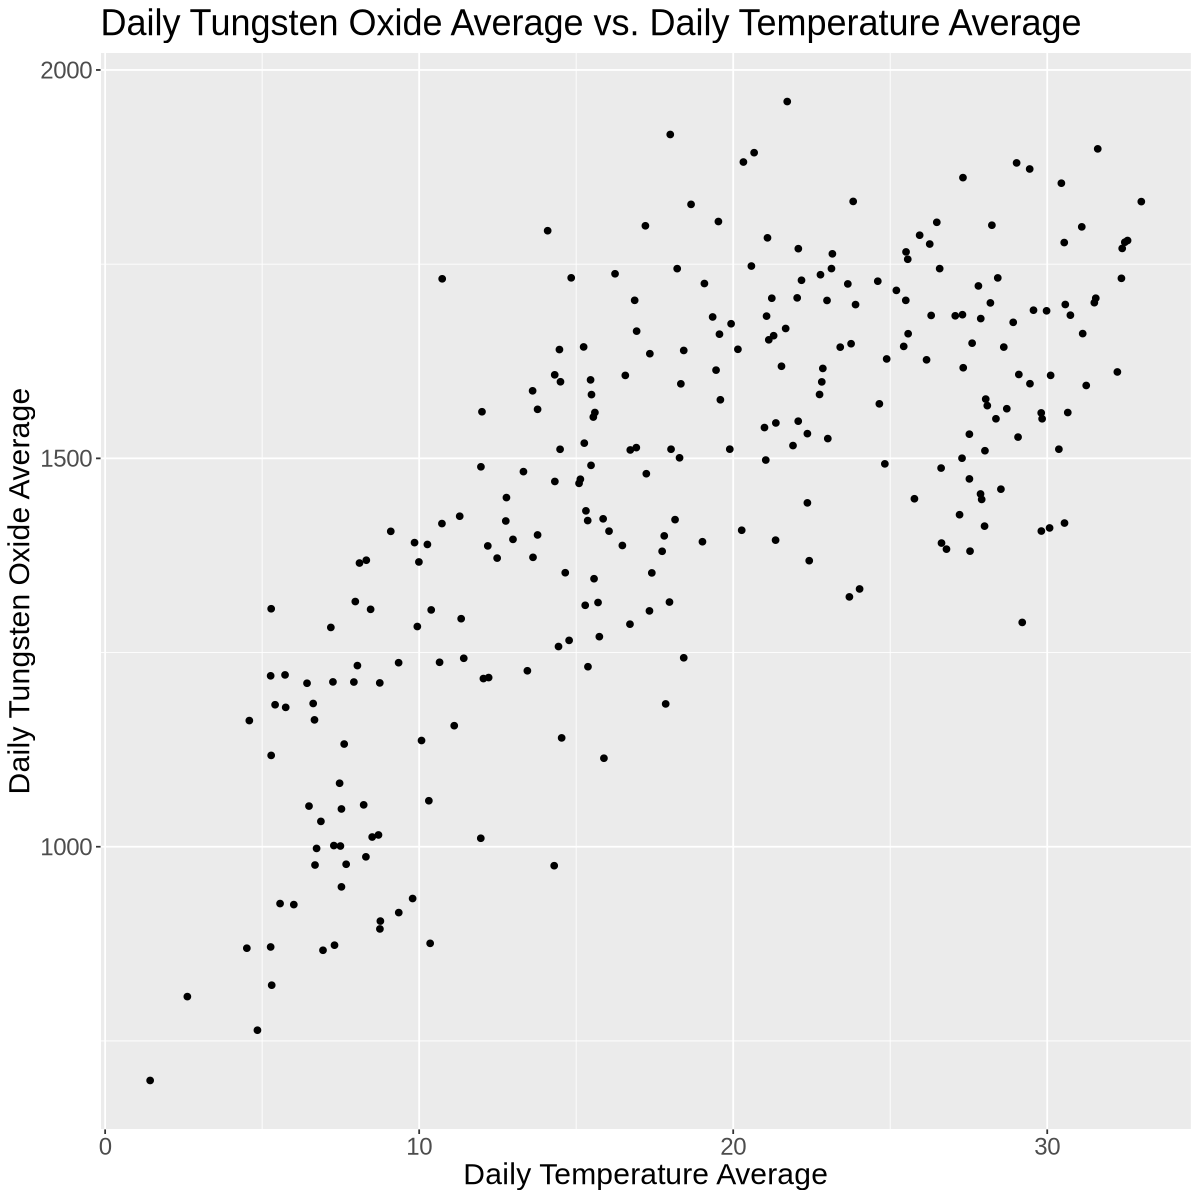

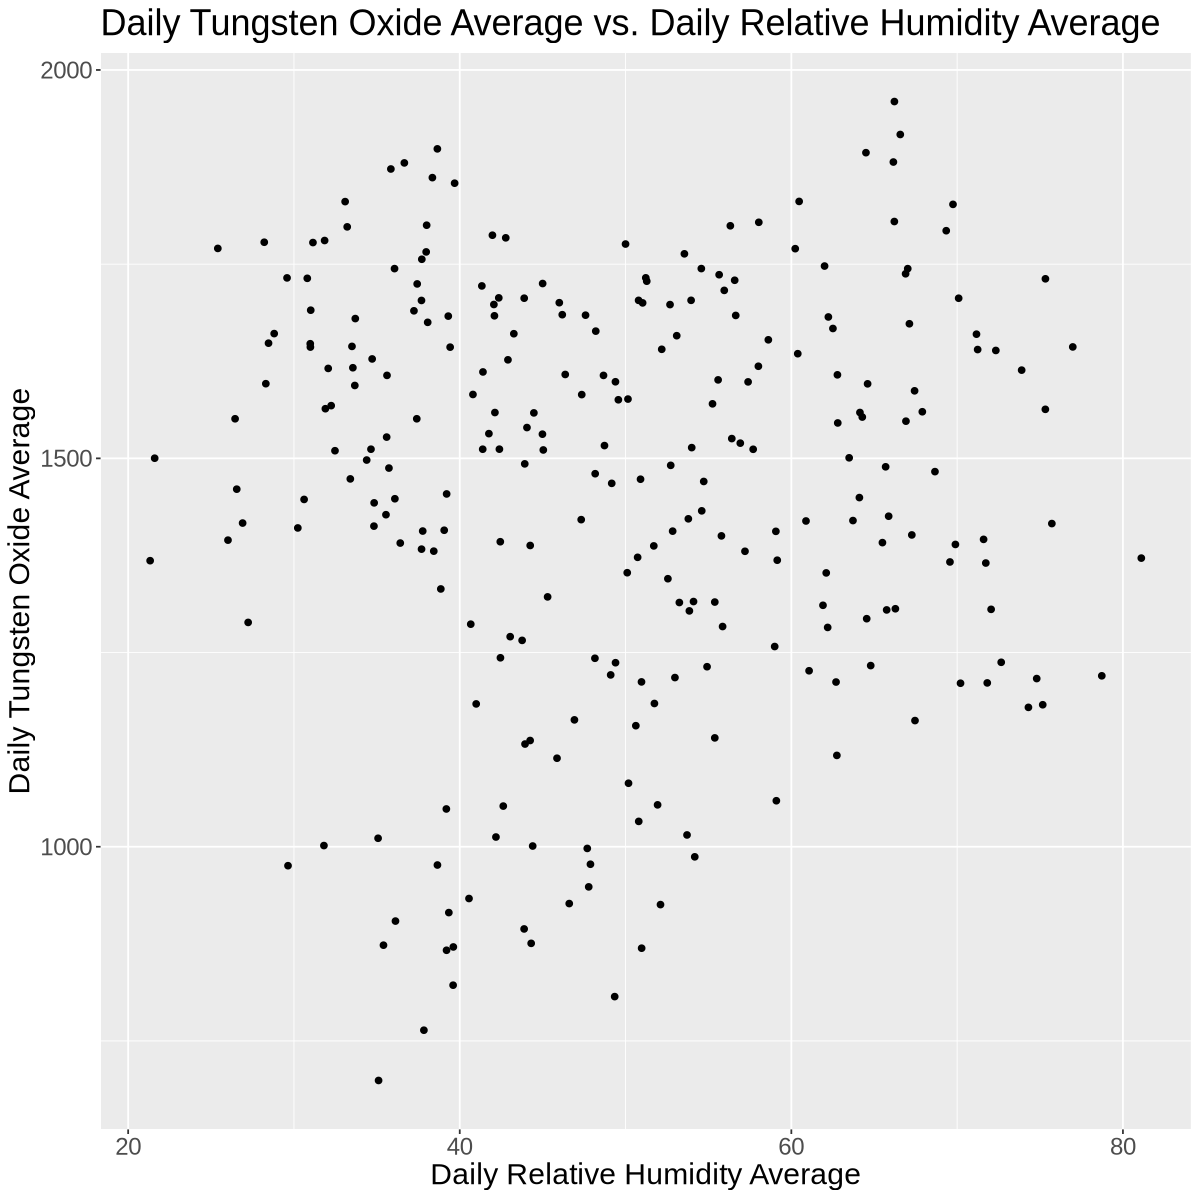

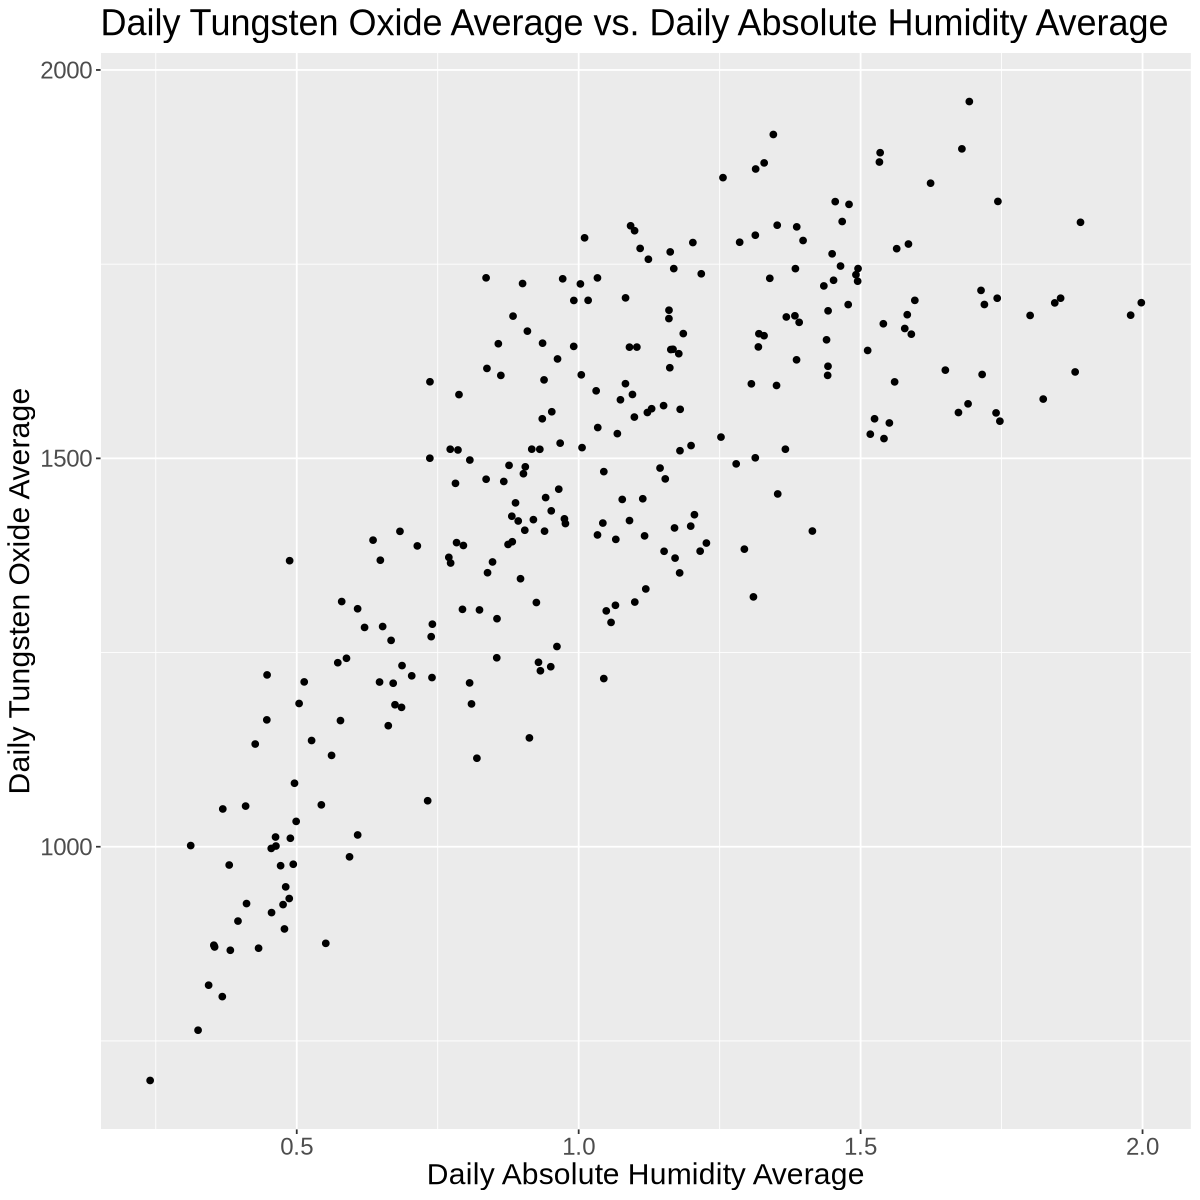

In [23]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(avg_air_quality_train, aes(x = daily_avg_T, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Temperature Average",
       x = "Daily Temperature Average",
       y = "Daily Tungsten Oxide Average") +
theme(text = element_text(size = 18))

ggplot(avg_air_quality_train, aes(x = daily_avg_RH, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Relative Humidity Average",
       x = "Daily Relative Humidity Average",
       y = "Daily Tungsten Oxide Average") +
theme(text = element_text(size = 18))

ggplot(avg_air_quality_train, aes(x = daily_avg_AH, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Absolute Humidity Average",
       x = "Daily Absolute Humidity Average",
       y = "Daily Tungsten Oxide Average") + 
theme(text = element_text(size = 18))


Following our data analysis and visualization, we expect to find that as temperature and humidity levels increase, more levels of tungsten oxide will be present in the atmosphere. We also expect chemical accumulation in the atmosphere over time, resulting in a regression line with a positive slope.These findings can be useful in determining how pollutant levels change overtime and if temperature and humidity levels can be good predictors. If they are not good predictors, then there will not be a clear relationship. These findings could also lead to questions such as: If we expanded the study by year from 2004 to 2022, would a relationship be more prominent? What are the large scale effects of pollutant accumulation? Are there any other factors besides pollutant accumulation which lead to increase AH, RH or temperature?  
